**Fair Learning with Private Demographic data**

Run notebook to reproduce Figure 1 in the paper.

# Imports

In [1]:
# If using Colab, uncomment to install required packages
#!pip install fairlearn
#!pip install shap
#!pip install pulp

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from fairlearn.reductions import GridSearch, ExponentiatedGradient
from fairlearn.reductions import DemographicParity, ErrorRate, EqualizedOdds, ErrorRateParity, UtilityParity

from sklearn import svm, neighbors, tree
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.linear_model import LogisticRegression
import pandas as pd
import shap
import numpy as np
import scipy.stats as st
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import io
import requests
import seaborn as sns
import pickle
import os
from pandas.api.types import CategoricalDtype
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score
import pulp
import math, copy
import matplotlib
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
import traceback



shap.initjs()
%matplotlib inline

# Algorithm and utilities

In [3]:
def measure_EO( Y , A, Yhat, y_value):
    '''
    
    we assume Y, A, Yhat are in the same order
    A is encoded as 0, 1, ...
    Y and Yhat are binary
    '''
    classes = len(set(A))
    Yhats = [0] * classes
    conditionals = [0] * classes
    for i in range(0,len(Y)):
        if Y[i] == y_value:
            Yhats[A[i]] += Yhat[i]
            conditionals[A[i]] += 1
    expectations = [0] * classes
    for i in range(0, classes):
        expectations[i] = Yhats[i] / (conditionals[i]) 
    EO_diff = []
    for i in range(0, classes):
        for j in range(i+1, classes):
            EO_diff.append(abs(expectations[i] - expectations[j]))
    EO_violation = max(EO_diff)
    return EO_violation
    

In [4]:
class PrivateFairPostprocessing_fixed:
    '''
    Our Post-processing algorithm for binary protected attributes
    '''
    def __init__(self, Y, Z ,Yhat, p, alpha):
        '''
        Y: labels on S_2
        Z: private attributes on S_2
        Yhat: predictions of first step predictor on S_2
        p: inversion probability  (Z is A flipped with probability p)
        alpha: constraint level (\alpha_n)
        '''
        self.p = p
        self.alpha = alpha
        p_yz0, p_yz1, p_haty = self.private_quantities(Y, Z, Yhat)
        p_yz = self.compute_pyz(Y,Z)
        p_ya = self.compute_pya(p_yz)
        p_hatya = self.required_quantities(p_haty, p_ya, p_yz)
        p_ya1, p_ya0 = self.compute_pyayh(p_yz0,p_yz1)
        self.tildeY = self.solve_lp(p_ya0, p_ya1, p_hatya) 
    
    
    def compute_pyayh(self, p_yz0, p_yz1):
        '''
        compute P(HATY, A , Y) by inversion
        '''
        p = self.p
        p_ya0 = [0] * 4 # P(haty, A , Y =0), p_ya0[2] = P(1,0,0), p_ya0[1] = P(0,1,0)
        p_ya1 = [0] * 4 # P(haty, A , Y =1)
        a0 = np.array([ p,1-p ])
        a1 = np.array([ 1-p,p ])
        a = np.array([a0,a1])

        b = np.array([p_yz0[2],p_yz0[3]])
        p_1a0 = np.linalg.solve(a, b) 
        
        b = np.array([p_yz1[2],p_yz1[3]])
        p_1a1 = np.linalg.solve(a, b) 
        
        b = np.array([p_yz0[0],p_yz0[1]])
        p_0a0 = np.linalg.solve(a, b)
        
        b = np.array([p_yz1[0],p_yz1[1]])
        p_0a1 = np.linalg.solve(a, b) 
        
        p_ya0[0:2] = p_0a0
        p_ya1[0:2] = p_0a1
        p_ya1[2:4] = p_1a1
        p_ya0[2:4] = p_1a0
        
        return p_ya0, p_ya1
    
    
    def compute_pyz(self, Y, Z):
        '''
        Compute P(Y=y,Z=a)
        '''
        p_yz = [0] * 4 # P( Z , Y), p_yz[2] = P(1,0), p_yz[1] = P(0,1)

        for i in range(0,len(Y)):
            p_yz[Z[i] + 2*Y[i]] += 1

        for i in range(0, 4):
            p_yz[i] /= len(Y)
            
        return p_yz
    
    
    def compute_pya(self, p_yz):
        '''
        Compute P(Y=y,A=a) by inversion
        '''
        p_ya = [0] * 4
        p = self.p
        a0 = np.array([ p,1-p ])
        a1 = np.array([ 1-p,p ])
        a = np.array([a0,a1])
        b = np.array([p_yz[0],p_yz[1]])
        p_0a = np.linalg.solve(a, b) #p_0a = P(Y=0,A=a)
        
        b = np.array([p_yz[2],p_yz[3]])
        p_1a = np.linalg.solve(a, b) #p_1a = P(Y=1,A=a)
        p_ya[0] = p_0a[0]
        p_ya[1] = p_0a[1]
        p_ya[2] = p_1a[0]
        p_ya[3] = p_1a[1]
        return p_ya 
    
    
    def private_quantities(self, Y, Z, Yhat):
        '''
        Assumed Z and Y are binary
        '''
        p_yz0 = [0] * 4 # P(haty, Z , Y =0), p_ya0[2] = P(1,0,0), p_ya0[1] = P(0,1,0)
        p_yz1 = [0] * 4 # P(haty, Z , Y =1)
        p_haty = [0] * 4 # P(haty=1| Z , Y)
        counts_haty = [0] *4

        for i in range(0,len(Y)):
            if Y[i] == 1:
                p_yz1[Z[i] + 2*Yhat[i]] += 1
            else:
                p_yz0[Z[i] + 2*Yhat[i]] += 1

            p_haty[Z[i] + 2*Y[i]] += Yhat[i]
            counts_haty[Z[i] + 2*Y[i]] += 1

        for i in range(0, 4):
            p_yz0[i] /= len(Y)
            p_yz1[i] /= len(Y)
            p_haty[i] = p_haty[i] / counts_haty[i]
        return p_yz0, p_yz1, p_haty
    
    
    def required_quantities(self, p_haty, p_ya, p_yz):
        '''
        Compute P(Yhat | Y=y, A =a)
        '''
        p = self.p
        a0 = np.array([ p *p_ya[2]/p_yz[2], (1-p)*p_ya[3]/p_yz[2] ])
        a1 = np.array([ (1-p) *p_ya[2]/p_yz[3], p*p_ya[3]/p_yz[3] ])

        a = np.array([a0,a1])
        b = np.array([p_haty[2],p_haty[3]])
        p_haty1 = np.linalg.solve(a, b) #p_haty1[0] = P(Yhat=1|Y=1, A=0)
        
        a0 = np.array([ p *p_ya[0]/p_yz[0], (1-p)*p_ya[1]/p_yz[0] ])
        a1 = np.array([ (1-p) *p_ya[0]/p_yz[1], p*p_ya[1]/p_yz[1] ])

        a = np.array([a0,a1])
        b = np.array([p_haty[0],p_haty[1]])
        p_haty0 = np.linalg.solve(a, b) #p_haty0[1] = P(Yhat=1|Y=0, A=1)
        p_haty = [0] * 4
        p_haty[0:2] = p_haty0
        p_haty[2:4] = p_haty1
        return p_haty
        
        
        
    def solve_lp(self, p_ya0, p_ya1, p_haty):
        '''
        Solve the LP and return the solution
        '''
        problem = pulp.LpProblem("fair-postprocess",pulp.LpMinimize)
        p_tildey = pulp.LpVariable.dicts("tildeY",list(range(0,4)),0,1,cat="Continuous")
        # c1 for y=0 and c2 for y=1, EO constraints
        p = self.p
        c11 = (p*p_tildey[1] + (1-p)*p_tildey[0])*(1-p_haty[1]) + (p*p_tildey[3] + (1-p)*p_tildey[2])*(p_haty[1]) - ((p*p_tildey[0] + (1-p)*p_tildey[1])*(1-p_haty[0]) + (p*p_tildey[2] + (1-p)*p_tildey[3])*(p_haty[0])) <=  self.alpha
        c12 = -((p*p_tildey[1] + (1-p)*p_tildey[0])*(1-p_haty[1]) + (p*p_tildey[3] + (1-p)*p_tildey[2])*(p_haty[1])) + (p*p_tildey[0] + (1-p)*p_tildey[1])*(1-p_haty[0]) + (p*p_tildey[2] + (1-p)*p_tildey[3])*(p_haty[0]) <=  self.alpha
        c21 = (p*p_tildey[1] + (1-p)*p_tildey[0])*(1-p_haty[3]) + (p*p_tildey[3] + (1-p)*p_tildey[2])*(p_haty[3]) - ((p*p_tildey[0] + (1-p)*p_tildey[1])*(1-p_haty[2]) + (p*p_tildey[2] + (1-p)*p_tildey[3])*(p_haty[2])) <=  self.alpha
        c22 = -((p*p_tildey[1] + (1-p)*p_tildey[0])*(1-p_haty[3]) + (p*p_tildey[3] + (1-p)*p_tildey[2])*(p_haty[3])) + (p*p_tildey[0] + (1-p)*p_tildey[1])*(1-p_haty[2]) + (p*p_tildey[2] + (1-p)*p_tildey[3])*(p_haty[2]) <=  self.alpha
        problem += c11
        problem += c12
        problem += c21
        problem += c22

        problem += (p_ya1[0]-p_ya0[0])*(p*p_tildey[0] + (1-p) * p_tildey[1]) + (p_ya1[1]-p_ya0[1])*(p*p_tildey[1] + (1-p) * p_tildey[0]) + (p_ya1[2]-p_ya0[2])*(p*p_tildey[2] + (1-p) * p_tildey[3]) + (p_ya1[3]-p_ya0[3])*(p*p_tildey[3] + (1-p) * p_tildey[2])
        problem.solve()
        solution = [p_tildey[i].varValue for i in range(0, 4)]
        return solution
    
    def predict_batch(self, Yhat, A):
        '''
        returns prediction of the post-processing algorithm
        Yhat: step 1 predictions on test set
        A: private protected attributes on test set
        '''
        Ytilde = []
        for i in range(0, len(Yhat)):
            prediction = np.random.binomial(1, self.p * self.tildeY[A[i] + 2*Yhat[i]] + (1-self.p) *self.tildeY[1-A[i] + 2*Yhat[i]] , 1)[0]
            Ytilde.append(prediction)
        return Ytilde

In [5]:
import json,os
from glob import glob
import traceback
import pickle

# Obtain Results

In [6]:
# # Load data
# def getdata1(path):
    
#     train_df = pd.read_csv(path+'train.csv',header=None)

#     train_df.columns = ['AGEP', 'SCHL', 'MAR', 'SEX', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC',
#        'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'PINCP', 'ESR', 'FER', 'RAC1P',
#        'PUBCOV']


#     train_df.index = train_df['SEX']
    
#     train_df['SEX'] = train_df['SEX'].map({'Male': 1, 'Female': 0})


#     train_df = train_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

#     test_df = pd.read_csv(path+'test.csv',header=None)

#     test_df.columns = ['AGEP', 'SCHL', 'MAR', 'SEX', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC',
#        'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'PINCP', 'ESR', 'FER', 'RAC1P',
#        'PUBCOV']


#     test_df.index = test_df['SEX']
    
#     test_df['SEX'] = test_df['SEX'].map({'Male': 1, 'Female': 0})


#     test_df = test_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
    
#     A_train = train_df['SEX']
#     A_test = test_df['SEX']

#     X_train = train_df.drop(['SEX','PUBCOV'],axis=1)
#     X_test = test_df.drop(['SEX','PUBCOV'],axis=1)

#     Y_train = pd.Series(train_df['PUBCOV'])
#     Y_test = pd.Series(test_df['PUBCOV'])

#     Y_train = pd.Series(Y_train.factorize(sort=True)[0], index=Y_train.index)
#     Y_test = pd.Series(Y_test.factorize(sort=True)[0], index=Y_test.index)

#     X_merged = pd.concat([X_train,X_test])

#     ohe = make_column_transformer(
#         (OneHotEncoder(sparse=False), X_merged.dtypes == 'object'),
#         remainder='passthrough', verbose_feature_names_out=False)

#     X_merged_temp  = pd.DataFrame(ohe.fit_transform(X_merged), columns=ohe.get_feature_names_out(), index=X_merged.index)

#     X_train  = pd.DataFrame(ohe.transform(X_train), columns=ohe.get_feature_names_out(), index=X_train.index)
#     X_test = pd.DataFrame(ohe.transform(X_test), columns=ohe.get_feature_names_out(), index=X_test.index)
    
#     return X_train, Y_train, A_train, X_test, Y_test, A_test

In [7]:
# # Load data
# def getdata2(path):
    
#     train_df = pd.read_csv(path+'train.csv',header=None)

#     train_df.columns = ['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC',
#        'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR']


#     train_df.index = train_df['SEX']
    
#     train_df['SEX'] = train_df['SEX'].map({'Male': 1, 'Female': 0})


#     train_df = train_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

#     test_df = pd.read_csv(path+'test.csv',header=None)

#     test_df.columns = ['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC',
#        'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR']


#     test_df.index = test_df['SEX']
    
#     test_df['SEX'] = test_df['SEX'].map({'Male': 1, 'Female': 0})


#     test_df = test_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
    
#     A_train = train_df['SEX']
#     A_test = test_df['SEX']

#     X_train = train_df.drop(['SEX','ESR'],axis=1)
#     X_test = test_df.drop(['SEX','ESR'],axis=1)

#     Y_train = pd.Series(train_df['ESR'])
#     Y_test = pd.Series(test_df['ESR'])

#     Y_train = pd.Series(Y_train.factorize(sort=True)[0], index=Y_train.index)
#     Y_test = pd.Series(Y_test.factorize(sort=True)[0], index=Y_test.index)

#     X_merged = pd.concat([X_train,X_test])

#     ohe = make_column_transformer(
#         (OneHotEncoder(sparse=False), X_merged.dtypes == 'object'),
#         remainder='passthrough', verbose_feature_names_out=False)

#     X_merged_temp  = pd.DataFrame(ohe.fit_transform(X_merged), columns=ohe.get_feature_names_out(), index=X_merged.index)

#     X_train  = pd.DataFrame(ohe.transform(X_train), columns=ohe.get_feature_names_out(), index=X_train.index)
#     X_test = pd.DataFrame(ohe.transform(X_test), columns=ohe.get_feature_names_out(), index=X_test.index)
    
#     return X_train, Y_train, A_train, X_test, Y_test, A_test

In [8]:
# Load data
def getdata3(path):
    
    train_df = pd.read_csv(path+'train.csv',header=None)

    train_df.columns = ['race', 'sex', 'age', 'admissiontypeid', 'dischargedispositionid',
       'admissionsourceid', 'timeinhospital', 'numlabprocedures',
       'numprocedures', 'nummedications', 'numberoutpatient',
       'numberemergency', 'numberinpatient', 'diag1', 'diag2', 'diag3',
       'numberdiagnoses', 'maxgluserum', 'A1Cresult', 'metformin',
       'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'insulin', 'change', 'diabetesMed', 'readmitted']


    train_df.index = train_df['sex']
    
    train_df['sex'] = train_df['sex'].map({'Male': 1, 'Female': 0})


    train_df = train_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

    test_df = pd.read_csv(path+'test.csv',header=None)

    test_df.columns = ['race', 'sex', 'age', 'admissiontypeid', 'dischargedispositionid',
       'admissionsourceid', 'timeinhospital', 'numlabprocedures',
       'numprocedures', 'nummedications', 'numberoutpatient',
       'numberemergency', 'numberinpatient', 'diag1', 'diag2', 'diag3',
       'numberdiagnoses', 'maxgluserum', 'A1Cresult', 'metformin',
       'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'insulin', 'change', 'diabetesMed', 'readmitted']

    test_df.index = test_df['sex']
    
    test_df['sex'] = test_df['sex'].map({'Male': 1, 'Female': 0})


    test_df = test_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
    
    A_train = train_df['sex']
    A_test = test_df['sex']

    X_train = train_df.drop(['sex','readmitted'],axis=1)
    X_test = test_df.drop(['sex','readmitted'],axis=1)

    Y_train = pd.Series(train_df['readmitted'])
    Y_test = pd.Series(test_df['readmitted'])

    Y_train = pd.Series(Y_train.factorize(sort=True)[0], index=Y_train.index)
    Y_test = pd.Series(Y_test.factorize(sort=True)[0], index=Y_test.index)

    X_merged = pd.concat([X_train,X_test])

    ohe = make_column_transformer(
        (OneHotEncoder(sparse=False), X_merged.dtypes == 'object'),
        remainder='passthrough', verbose_feature_names_out=False)

    X_merged_temp  = pd.DataFrame(ohe.fit_transform(X_merged), columns=ohe.get_feature_names_out(), index=X_merged.index)

    X_train  = pd.DataFrame(ohe.transform(X_train), columns=ohe.get_feature_names_out(), index=X_train.index)
    X_test = pd.DataFrame(ohe.transform(X_test), columns=ohe.get_feature_names_out(), index=X_test.index)
    
    return X_train, Y_train, A_train, X_test, Y_test, A_test

In [10]:
# Load data
def getdata4(path):
    
    train_df = pd.read_csv(path+'train.csv',header=None)

    train_df.columns = ['zfygpa', 'zgpa', 'DOByr', 'weightedlsatugpa', 'clustertier',
           'familyincome', 'lsat', 'ugpa', 'isPartTime', 'sex', 'race',
           'pass_bar']


    train_df.index = train_df['sex']
    
    train_df['sex'] = train_df['sex'].map({'Male': 1, 'Female': 0})


    train_df = train_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

    test_df = pd.read_csv(path+'test.csv',header=None)

    test_df.columns = ['zfygpa', 'zgpa', 'DOByr', 'weightedlsatugpa', 'clustertier',
           'familyincome', 'lsat', 'ugpa', 'isPartTime', 'sex', 'race',
           'pass_bar']

    test_df.index = test_df['sex']
    
    test_df['sex'] = test_df['sex'].map({'Male': 1, 'Female': 0})


    test_df = test_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
    
    A_train = train_df['sex']
    A_test = test_df['sex']

    X_train = train_df.drop(['sex','pass_bar'],axis=1)
    X_test = test_df.drop(['sex','pass_bar'],axis=1)

    Y_train = pd.Series(train_df['pass_bar'])
    Y_test = pd.Series(test_df['pass_bar'])

    Y_train = pd.Series(Y_train.factorize(sort=True)[0], index=Y_train.index)
    Y_test = pd.Series(Y_test.factorize(sort=True)[0], index=Y_test.index)

    X_merged = pd.concat([X_train,X_test])

    ohe = make_column_transformer(
        (OneHotEncoder(sparse=False), X_merged.dtypes == 'object'),
        remainder='passthrough', verbose_feature_names_out=False)

    X_merged_temp  = pd.DataFrame(ohe.fit_transform(X_merged), columns=ohe.get_feature_names_out(), index=X_merged.index)

    X_train  = pd.DataFrame(ohe.transform(X_train), columns=ohe.get_feature_names_out(), index=X_train.index)
    X_test = pd.DataFrame(ohe.transform(X_test), columns=ohe.get_feature_names_out(), index=X_test.index)
    
    return X_train, Y_train, A_train, X_test, Y_test, A_test

In [9]:
# experimental parameters
exp = 0
#[-2,-1,-0.75,-0.5,-0.25,-0.1,0.1,0.25,0.5,1,1.5,2]

In [12]:
def dothings(X_test, A_test_corr, fair, step1, name):
    
    def f(X_test_copy):
        A_drop = [int(a) for a in X_test_copy['SEX']]
        X_drop = X_test_copy.drop(['SEX'],axis=1)
        predictions = fair.predict_batch(step1.predict(X_drop), A_drop)
        preds = [int(p) for p in predictions]
        return preds

    X_test_copy = copy.deepcopy(X_test)
    X_test_copy['SEX'] = A_test_corr
    explainer = shap.Explainer(f, X_test_copy)
    shap_values = explainer(X_test_copy.sample(n=500))
    
    clist = list(X_test_copy.columns)
    features = {}
    for i in range(len(clist)):
        fname = clist[i]
        item = fname.split('_')[0]
        if item not in features:
            features[item]=[]
        features[item].append(i)
    newshap = {}
    for k in features:
        nshap = []
        for x in shap_values.values:
            val = 0
            for i in features[k]:
                val+= x[i]
            nshap.append(val)
        newshap[k] = nshap
    new_shap_values = list(zip(*newshap.values()))
    shap_values.values = np.array(new_shap_values)
    shap_values.feature_names = list(features.keys())
    
    f = open('SavedShap/'+name+'.pkl','wb')
    pickle.dump(shap_values,f)
    f.close()
    
    shap.plots.bar(shap_values,max_display=18)

In [10]:
def dothings2(X_test, A_test_corr, fair, step1, name):
    
    def f(X_test_copy):
        A_drop = [int(a) for a in X_test_copy['sex']]
        X_drop = X_test_copy.drop(['sex'],axis=1)
        predictions = fair.predict_batch(step1.predict(X_drop), A_drop)
        preds = [int(p) for p in predictions]
        return preds

    X_test_copy = copy.deepcopy(X_test)
    X_test_copy['sex'] = A_test_corr
    explainer = shap.Explainer(f, X_test_copy)
    shap_values = explainer(X_test_copy.sample(n=500))
    
    clist = list(X_test_copy.columns)
    features = {}
    for i in range(len(clist)):
        fname = clist[i]
        item = fname.split('_')[0]
        if item not in features:
            features[item]=[]
        features[item].append(i)
    newshap = {}
    for k in features:
        nshap = []
        for x in shap_values.values:
            val = 0
            for i in features[k]:
                val+= x[i]
            nshap.append(val)
        newshap[k] = nshap
    new_shap_values = list(zip(*newshap.values()))
    shap_values.values = np.array(new_shap_values)
    shap_values.feature_names = list(features.keys())
    
    f = open('SavedShap/'+name+'.pkl','wb')
    pickle.dump(shap_values,f)
    f.close()
    
    shap.plots.bar(shap_values,max_display=18)

data/datasets/diabetes/
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/avijit/anaconda3/envs/pablo/lib/python3.7/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/0e7353511474407792d25cc5b027537f-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/0e7353511474407792d25cc5b027537f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 30 RHS
At line 35 BOUNDS
At line 40 ENDATA
Problem MODEL has 4 rows, 4 columns and 16 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 4 (0) rows, 4 (0) columns and 16 (0) elements
0  Obj 0 Dual inf 0.09662228 (2)
2  Obj -0.0090322196
Optimal - objective value -0.0090322196
Optimal objective -0.009032219649 - 2 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00



Permutation explainer: 501it [03:23,  2.36it/s]                                 


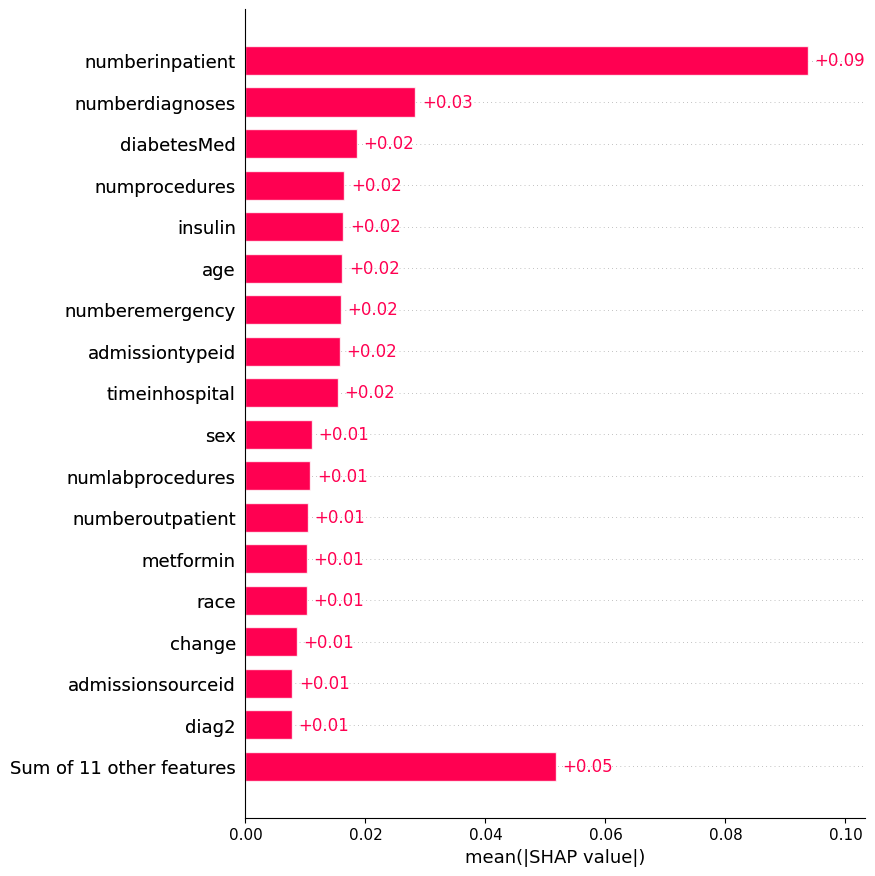

data/datasets/diabetes/synthetic/gender_flip_labels0.2_version0/
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/avijit/anaconda3/envs/pablo/lib/python3.7/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/1722c41bb9584f3891a0f905cc34becf-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/1722c41bb9584f3891a0f905cc34becf-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 30 RHS
At line 35 BOUNDS
At line 40 ENDATA
Problem MODEL has 4 rows, 4 columns and 16 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 4 (0) rows, 4 (0) columns and 16 (0) elements
0  Obj 0 Dual inf 0.091839039 (2)
2  Obj -0.02016452
Optimal - objective value -0.02016452
Optimal objective -0.02016452008 - 2 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00



Permutation explainer: 501it [03:22,  2.35it/s]                                 


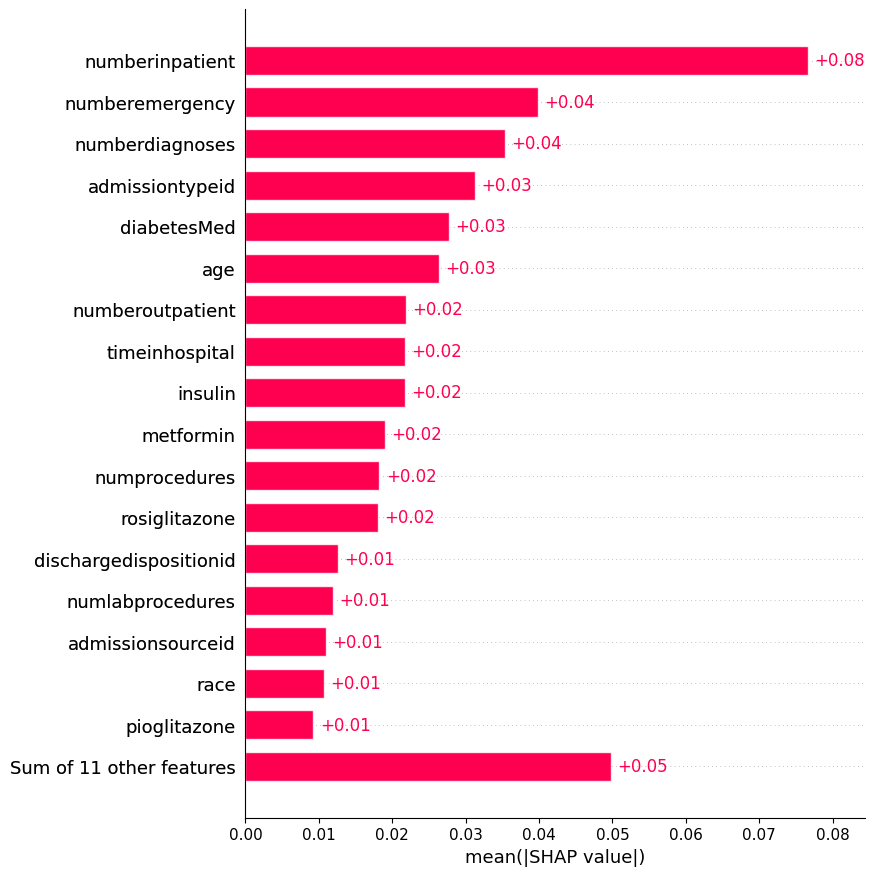

data/datasets/diabetes/synthetic/gender_flip_labels0.4_version0/
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/avijit/anaconda3/envs/pablo/lib/python3.7/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/aa0a7e09c99a4763b5b974b0d60ac430-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/aa0a7e09c99a4763b5b974b0d60ac430-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 30 RHS
At line 35 BOUNDS
At line 40 ENDATA
Problem MODEL has 4 rows, 4 columns and 16 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 4 (0) rows, 4 (0) columns and 16 (0) elements
0  Obj 0 Dual inf 0.1070667 (2)
2  Obj -0.020440495
Optimal - objective value -0.020440495
Optimal objective -0.02044049494 - 2 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00



Permutation explainer: 501it [03:17,  2.42it/s]                                 


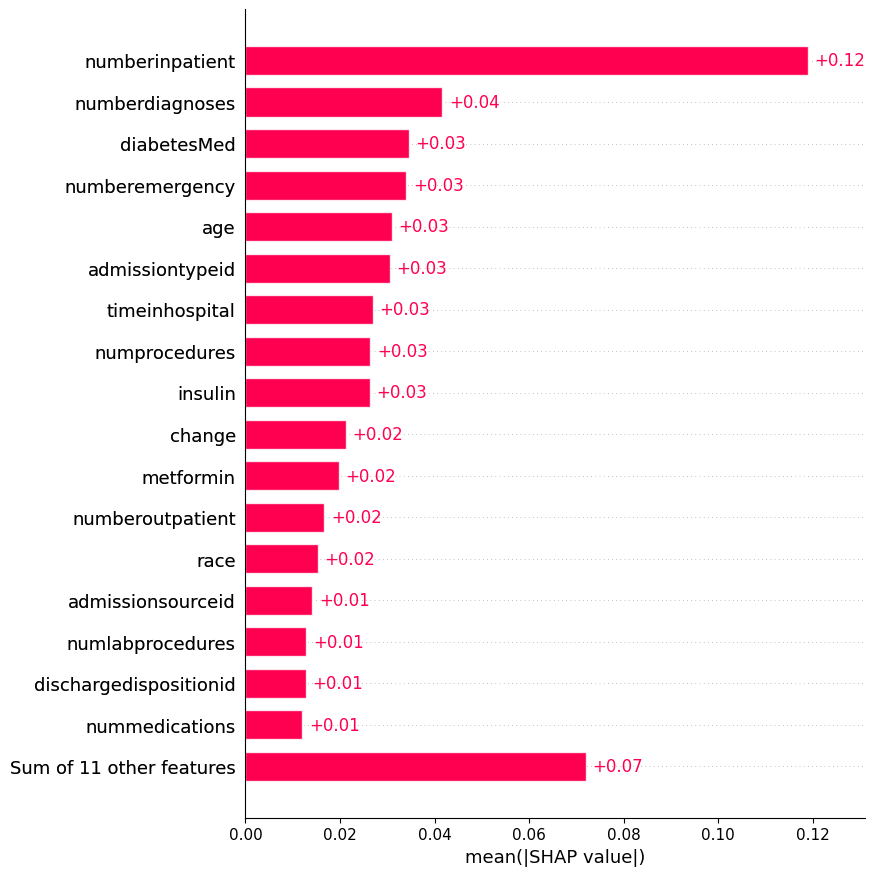

data/datasets/diabetes/synthetic/gender_flip_labels0.6_version0/
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/avijit/anaconda3/envs/pablo/lib/python3.7/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/23cb8109f288424a995b0aaac4e1606f-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/23cb8109f288424a995b0aaac4e1606f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 30 RHS
At line 35 BOUNDS
At line 40 ENDATA
Problem MODEL has 4 rows, 4 columns and 16 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 4 (0) rows, 4 (0) columns and 16 (0) elements
0  Obj 0 Dual inf 0.10175679 (2)
2  Obj -0.016428028
Optimal - objective value -0.016428028
Optimal objective -0.01642802829 - 2 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00



Permutation explainer: 501it [05:02,  1.62it/s]                                 


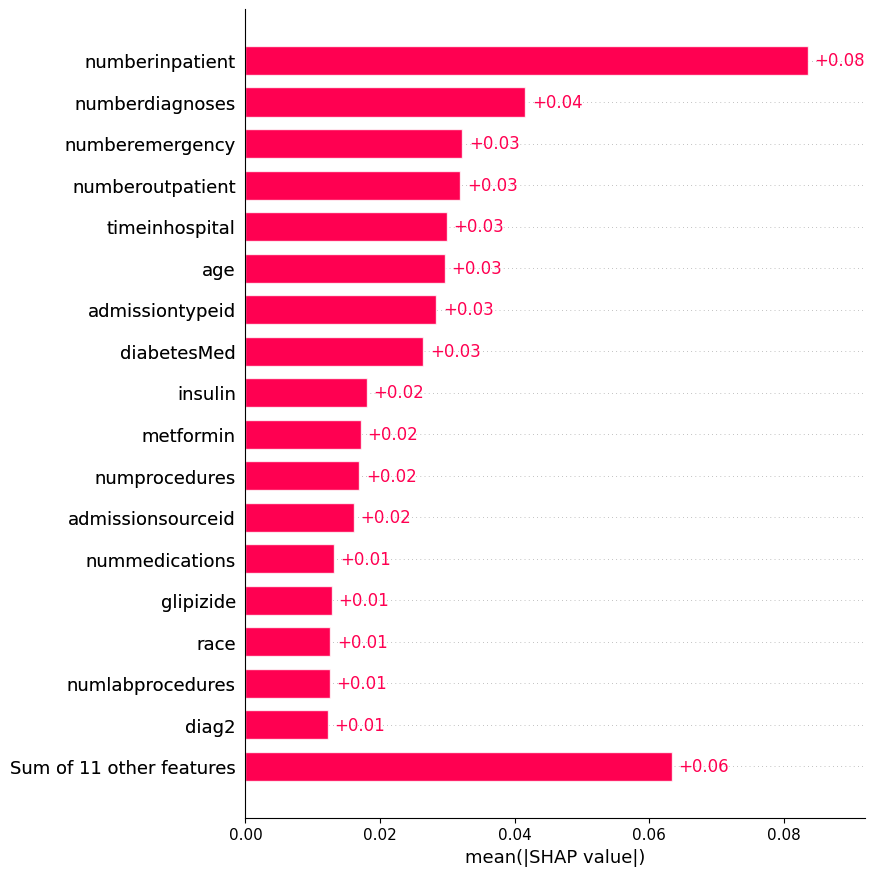

data/datasets/diabetes/synthetic/gender_flip_labels0.8_version0/
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/avijit/anaconda3/envs/pablo/lib/python3.7/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/e921df4ef10b4a94876cb37463dbdcaf-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/e921df4ef10b4a94876cb37463dbdcaf-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 30 RHS
At line 35 BOUNDS
At line 40 ENDATA
Problem MODEL has 4 rows, 4 columns and 16 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 4 (0) rows, 4 (0) columns and 16 (0) elements
0  Obj 0 Dual inf 0.10855768 (2)
2  Obj -0.019560828
Optimal - objective value -0.019560828
Optimal objective -0.01956082798 - 2 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00



Permutation explainer: 501it [03:02,  2.62it/s]                                 


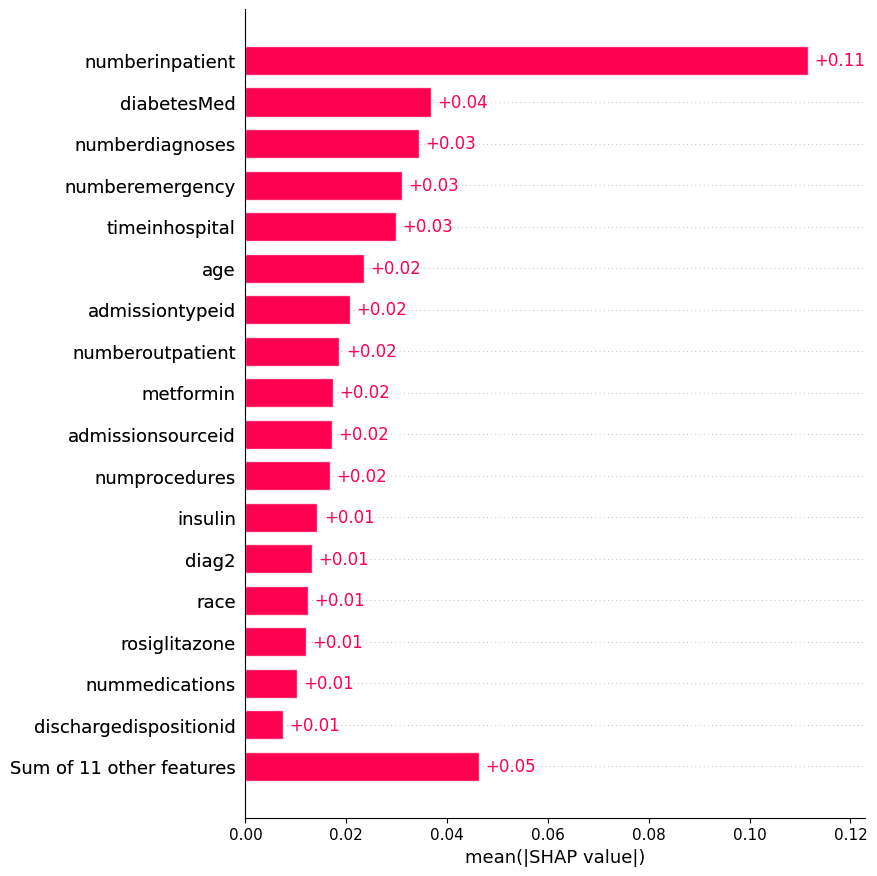

In [11]:
paths = {0:'data/datasets/diabetes/',
         0.2:'data/datasets/diabetes/synthetic/gender_flip_labels0.2_version0/',
         0.4:'data/datasets/diabetes/synthetic/gender_flip_labels0.4_version0/',
         0.6:'data/datasets/diabetes/synthetic/gender_flip_labels0.6_version0/',
         0.8:'data/datasets/diabetes/synthetic/gender_flip_labels0.8_version0/'
        }

for frac in paths:
    
    path = paths[frac]
    
    print(path)
    gname = 'diabetes'
    
    X_train, Y_train, A_train, X_test, Y_test, A_test = getdata3(path)

    X_train, X_val, Y_train, Y_val, A_train, A_val = train_test_split(X_train, 
                                                        Y_train, 
                                                        A_train,
                                                        test_size = 0.5,
                                                        #random_state=0,
                                                        stratify=Y_train)

    # Work around indexing bug
    X_train = X_train.reset_index(drop=True)
    A_train = A_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    A_test = A_test.reset_index(drop=True)
    X_val = X_val.reset_index(drop=True)
    A_val = A_val.reset_index(drop=True)
    # get Z from A 
    epsilon = 10**exp
    pi = math.exp(epsilon) / (math.exp(epsilon)  +1)
    for i in range(0,len(A_train)):
        coin = np.random.binomial(1, pi, 1)[0]
        if coin == 0:
            A_train[i] = abs(A_train[i]-1)
    for i in range(0,len(A_val)):
        coin = np.random.binomial(1, pi, 1)[0]
        if coin == 0:
            A_val[i] = abs(A_val[i]-1)

    A_test_corr = copy.deepcopy(A_test)
    for i in range(0,len(A_test_corr)):
        coin = np.random.binomial(1, pi, 1)[0]
        if coin == 0:
            A_test_corr[i] = abs(A_test_corr[i]-1)



    # learn step 1 on train
    step1 = ExponentiatedGradient(LogisticRegression(solver='liblinear', fit_intercept=True),
                                    constraints=EqualizedOdds(),
                                     eps= 0.001,
                                     max_iter=50,
                                     eta0 = 0.5)
    step1.fit(X_train, Y_train, sensitive_features=A_train)

    alpha_n = 0.0001

    # learn step 2 on val
    fair = PrivateFairPostprocessing_fixed(Y_val, A_val, step1.predict(X_val), pi, alpha_n)

    A_test_corr = copy.deepcopy(A_test)
    
    name = gname+'_private_'+str(frac)
    dothings2(X_test, A_test_corr, fair, step1, name)

data/datasets/law_school/
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/avijit/anaconda3/envs/pablo/lib/python3.7/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/20cc783fd16f40e5836d35ffc32e3750-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/20cc783fd16f40e5836d35ffc32e3750-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 30 RHS
At line 35 BOUNDS
At line 40 ENDATA
Problem MODEL has 4 rows, 4 columns and 16 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 4 (0) rows, 4 (0) columns and 16 (0) elements
0  Obj 0 Dual inf 0.076527865 (2)
2  Obj -0.61791221
Optimal - objective value -0.61791221
Optimal objective -0.6179122086 - 2 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00



Permutation explainer: 501it [03:41,  2.13it/s]                                 


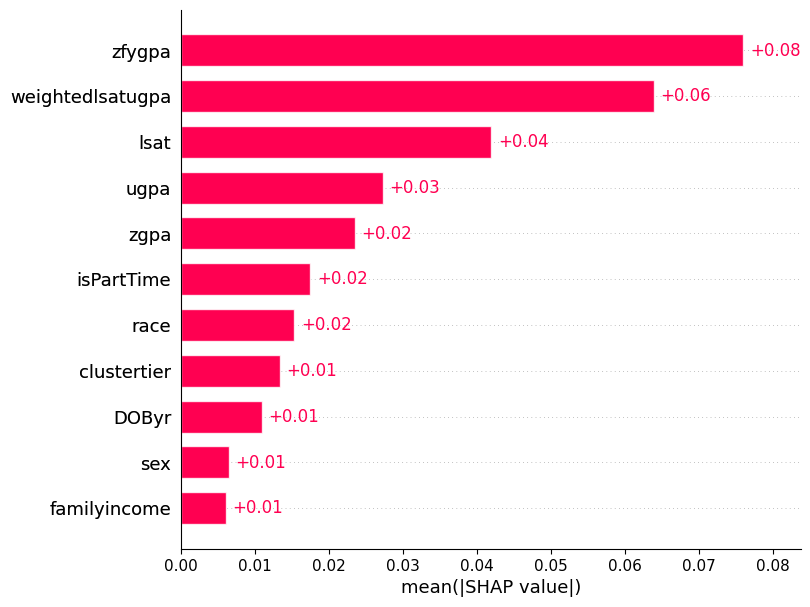

data/datasets/law_school/synthetic/gender_flip_labels0.2_version0/
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/avijit/anaconda3/envs/pablo/lib/python3.7/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/53736085c1e2411f942fca567b1f4dbd-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/53736085c1e2411f942fca567b1f4dbd-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 30 RHS
At line 35 BOUNDS
At line 40 ENDATA
Problem MODEL has 4 rows, 4 columns and 16 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 4 (0) rows, 4 (0) columns and 16 (0) elements
0  Obj 0 Dual inf 0.078963673 (2)
2  Obj -0.61929131
Optimal - objective value -0.61929131
Optimal objective -0.619291308 - 2 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00



Permutation explainer: 501it [04:38,  1.72it/s]                                 


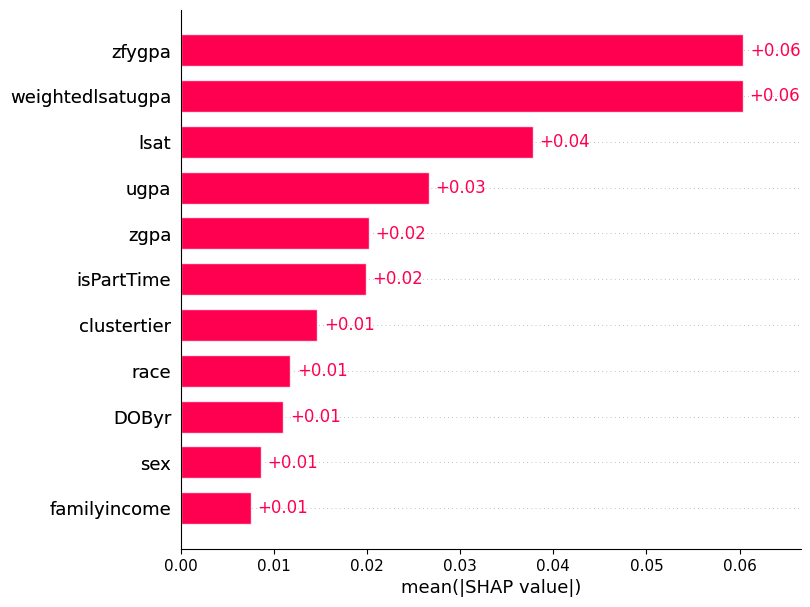

data/datasets/law_school/synthetic/gender_flip_labels0.4_version0/
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/avijit/anaconda3/envs/pablo/lib/python3.7/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/0e50b61116e24c6baf023cfee2a81c33-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/0e50b61116e24c6baf023cfee2a81c33-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 30 RHS
At line 35 BOUNDS
At line 40 ENDATA
Problem MODEL has 4 rows, 4 columns and 16 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 4 (0) rows, 4 (0) columns and 16 (0) elements
0  Obj 0 Dual inf 0.07085122 (2)
2  Obj -0.61178454
Optimal - objective value -0.61178454
Optimal objective -0.6117845414 - 2 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00



Permutation explainer: 501it [03:46,  2.13it/s]                                 


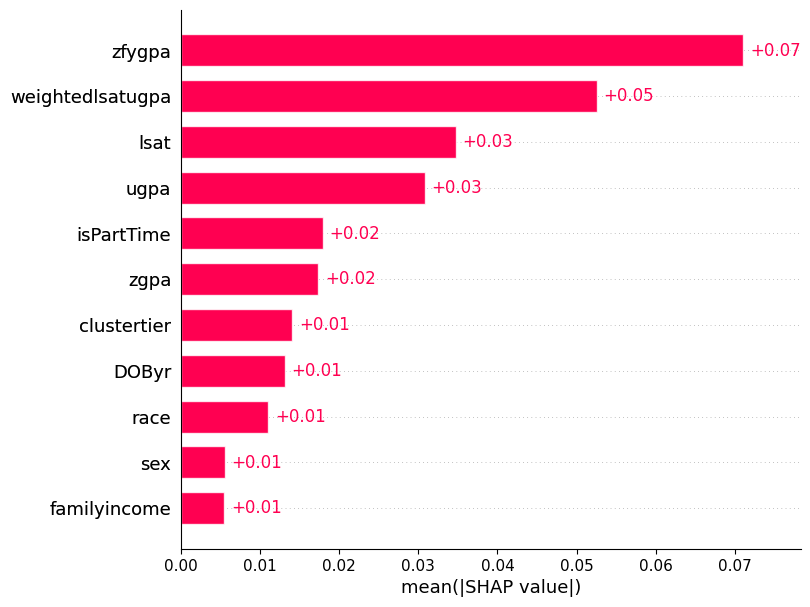

data/datasets/law_school/synthetic/gender_flip_labels0.6_version0/
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/avijit/anaconda3/envs/pablo/lib/python3.7/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/46a89f6829ca45e09b8102c300ca3bc3-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/46a89f6829ca45e09b8102c300ca3bc3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 30 RHS
At line 35 BOUNDS
At line 40 ENDATA
Problem MODEL has 4 rows, 4 columns and 16 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 4 (0) rows, 4 (0) columns and 16 (0) elements
0  Obj 0 Dual inf 0.082308769 (2)
2  Obj -0.62604445
Optimal - objective value -0.62604445
Optimal objective -0.6260444491 - 2 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00



Permutation explainer: 501it [03:51,  2.08it/s]                                 


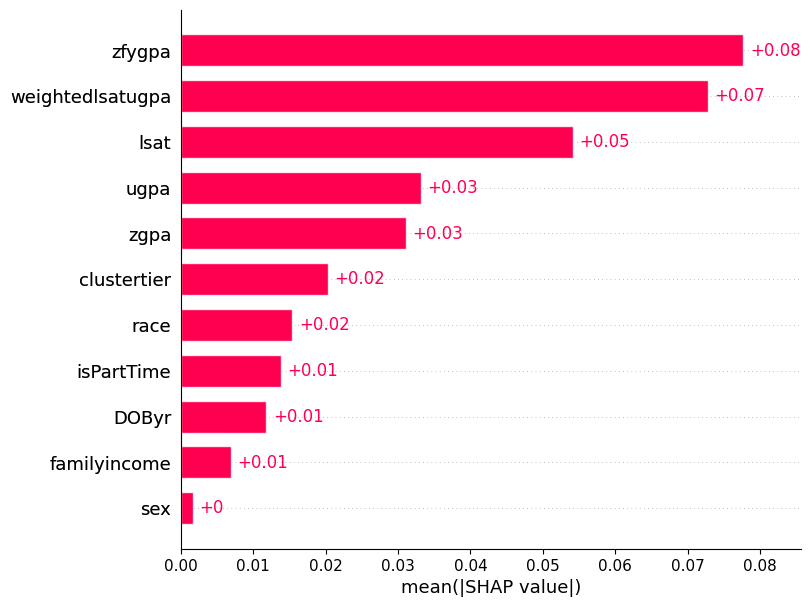

data/datasets/law_school/synthetic/gender_flip_labels0.8_version0/
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/avijit/anaconda3/envs/pablo/lib/python3.7/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/576dd4b010634a40a06ba70365bbae56-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/576dd4b010634a40a06ba70365bbae56-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 30 RHS
At line 35 BOUNDS
At line 40 ENDATA
Problem MODEL has 4 rows, 4 columns and 16 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 4 (0) rows, 4 (0) columns and 16 (0) elements
0  Obj 0 Dual inf 0.066861409 (2)
2  Obj -0.61028443
Optimal - objective value -0.61028443
Optimal objective -0.610284429 - 2 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00



Permutation explainer: 501it [03:29,  2.25it/s]                                 


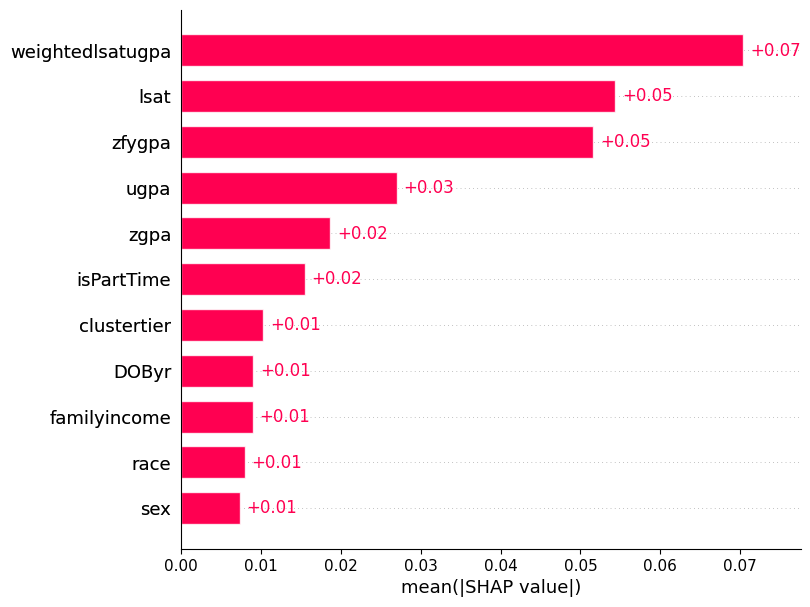

In [15]:
paths = {0:'data/datasets/law_school/',
         0.2:'data/datasets/law_school/synthetic/gender_flip_labels0.2_version0/',
         0.4:'data/datasets/law_school/synthetic/gender_flip_labels0.4_version0/',
         0.6:'data/datasets/law_school/synthetic/gender_flip_labels0.6_version0/',
         0.8:'data/datasets/law_school/synthetic/gender_flip_labels0.8_version0/'
        }

for frac in paths:
    
    path = paths[frac]
    
    print(path)
    gname = 'law_school'
    
    X_train, Y_train, A_train, X_test, Y_test, A_test = getdata4(path)

    X_train, X_val, Y_train, Y_val, A_train, A_val = train_test_split(X_train, 
                                                        Y_train, 
                                                        A_train,
                                                        test_size = 0.5,
                                                        #random_state=0,
                                                        stratify=Y_train)

    # Work around indexing bug
    X_train = X_train.reset_index(drop=True)
    A_train = A_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    A_test = A_test.reset_index(drop=True)
    X_val = X_val.reset_index(drop=True)
    A_val = A_val.reset_index(drop=True)
    # get Z from A 
    epsilon = 10**exp
    pi = math.exp(epsilon) / (math.exp(epsilon)  +1)
    for i in range(0,len(A_train)):
        coin = np.random.binomial(1, pi, 1)[0]
        if coin == 0:
            A_train[i] = abs(A_train[i]-1)
    for i in range(0,len(A_val)):
        coin = np.random.binomial(1, pi, 1)[0]
        if coin == 0:
            A_val[i] = abs(A_val[i]-1)

    A_test_corr = copy.deepcopy(A_test)
    for i in range(0,len(A_test_corr)):
        coin = np.random.binomial(1, pi, 1)[0]
        if coin == 0:
            A_test_corr[i] = abs(A_test_corr[i]-1)



    # learn step 1 on train
    step1 = ExponentiatedGradient(LogisticRegression(solver='liblinear', fit_intercept=True),
                                    constraints=EqualizedOdds(),
                                     eps= 0.001,
                                     max_iter=50,
                                     eta0 = 0.5)
    step1.fit(X_train, Y_train, sensitive_features=A_train)

    alpha_n = 0.0001

    # learn step 2 on val
    fair = PrivateFairPostprocessing_fixed(Y_val, A_val, step1.predict(X_val), pi, alpha_n)

    A_test_corr = copy.deepcopy(A_test)
    
    name = gname+'_private_'+str(frac)
    dothings2(X_test, A_test_corr, fair, step1, name)

Obtain results for baseline step-1

In [ ]:
# paths = {0:'data/datasets/publiccov_ca/',
#          0.2:'data/datasets/publiccov_ca/synthetic/gender_flip_labels0.2_version0/',
#          0.4:'data/datasets/publiccov_ca/synthetic/gender_flip_labels0.4_version0/',
#          0.6:'data/datasets/publiccov_ca/synthetic/gender_flip_labels0.6_version0/',
#          0.8:'data/datasets/publiccov_ca/synthetic/gender_flip_labels0.8_version0/'
#         }

# for frac in paths:
    
#     path = paths[frac]
    
#     print(path)
#     gname = 'publiccov_ca'
    
#     X_train, Y_train, A_train, X_test, Y_test, A_test = getdata1(path)

#     X_train, X_val, Y_train, Y_val, A_train, A_val = train_test_split(X_train, 
#                                                         Y_train, 
#                                                         A_train,
#                                                         test_size = 0.5,
#                                                         #random_state=0,
#                                                         stratify=Y_train)

#     # Work around indexing bug
#     X_train = X_train.reset_index(drop=True)
#     A_train = A_train.reset_index(drop=True)
#     X_test = X_test.reset_index(drop=True)
#     A_test = A_test.reset_index(drop=True)
#     X_val = X_val.reset_index(drop=True)
#     A_val = A_val.reset_index(drop=True)
#     # get Z from A 
#     epsilon = 10**exp
#     pi = math.exp(epsilon) / (math.exp(epsilon)  +1)
#     for i in range(0,len(A_train)):
#         coin = np.random.binomial(1, pi, 1)[0]
#         if coin == 0:
#             A_train[i] = abs(A_train[i]-1)
#     for i in range(0,len(A_val)):
#         coin = np.random.binomial(1, pi, 1)[0]
#         if coin == 0:
#             A_val[i] = abs(A_val[i]-1)

#     A_test_corr = copy.deepcopy(A_test)
#     for i in range(0,len(A_test_corr)):
#         coin = np.random.binomial(1, pi, 1)[0]
#         if coin == 0:
#             A_test_corr[i] = abs(A_test_corr[i]-1)



#     # learn step 1 on train
#     step1 = ExponentiatedGradient(LogisticRegression(solver='liblinear', fit_intercept=True),
#                                     constraints=EqualizedOdds(),
#                                      eps= 0.001,
#                                      max_iter=50,
#                                      eta0 = 0.5)
#     step1.fit(X_train, Y_train, sensitive_features=A_train)

#     alpha_n = 0.0001

#     # learn step 2 on val
#     fair = PrivateFairPostprocessing_fixed(Y_val, A_val, step1.predict(X_val), pi, alpha_n)

#     A_test_corr = copy.deepcopy(A_test)
    
#     name = gname+'_private_'+str(frac)
#     dothings(X_test, A_test_corr, fair, step1, name)
    

In [ ]:
# paths = {0:'data/datasets/employment_ca/',
#          0.2:'data/datasets/employment_ca/synthetic/gender_flip_labels0.2_version0/',
#          0.4:'data/datasets/employment_ca/synthetic/gender_flip_labels0.4_version0/',
#          0.6:'data/datasets/employment_ca/synthetic/gender_flip_labels0.6_version0/',
#          0.8:'data/datasets/employment_ca/synthetic/gender_flip_labels0.8_version0/'
#         }

# for frac in paths:
    
#     path = paths[frac]
#     print(path)
#     gname = 'employment_ca'
    
#     X_train, Y_train, A_train, X_test, Y_test, A_test = getdata2(path)

#     X_train, X_val, Y_train, Y_val, A_train, A_val = train_test_split(X_train, 
#                                                         Y_train, 
#                                                         A_train,
#                                                         test_size = 0.5,
#                                                         #random_state=0,
#                                                         stratify=Y_train)

#     # Work around indexing bug
#     X_train = X_train.reset_index(drop=True)
#     A_train = A_train.reset_index(drop=True)
#     X_test = X_test.reset_index(drop=True)
#     A_test = A_test.reset_index(drop=True)
#     X_val = X_val.reset_index(drop=True)
#     A_val = A_val.reset_index(drop=True)
#     # get Z from A 
#     epsilon = 10**exp
#     pi = math.exp(epsilon) / (math.exp(epsilon)  +1)
#     for i in range(0,len(A_train)):
#         coin = np.random.binomial(1, pi, 1)[0]
#         if coin == 0:
#             A_train[i] = abs(A_train[i]-1)
#     for i in range(0,len(A_val)):
#         coin = np.random.binomial(1, pi, 1)[0]
#         if coin == 0:
#             A_val[i] = abs(A_val[i]-1)

#     A_test_corr = copy.deepcopy(A_test)
#     for i in range(0,len(A_test_corr)):
#         coin = np.random.binomial(1, pi, 1)[0]
#         if coin == 0:
#             A_test_corr[i] = abs(A_test_corr[i]-1)



#     # learn step 1 on train
#     step1 = ExponentiatedGradient(LogisticRegression(solver='liblinear', fit_intercept=True),
#                                     constraints=EqualizedOdds(),
#                                      eps= 0.001,
#                                      max_iter=50,
#                                      eta0 = 0.5)
#     step1.fit(X_train, Y_train, sensitive_features=A_train)

#     alpha_n = 0.0001

#     # learn step 2 on val
#     fair = PrivateFairPostprocessing_fixed(Y_val, A_val, step1.predict(X_val), pi, alpha_n)

#     A_test_corr = copy.deepcopy(A_test)
    
#     name = gname+'_private_'+str(frac)
#     dothings(X_test, A_test_corr,fair, step1, name)